In [1]:
# %pip install gymnasium imageio swig
# %pip install "gymnasium[classic-control]"
# %pip install "gymnasium[box2d]"

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
import imageio
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Reinforcement Learning

**Reinforcement Learning (RL)** is a paradigm of machine learning in which an **agent** learns to make decisions by interacting with an **environment**.
Instead of learning from labeled data (as in supervised learning), the agent learns by **trial and error**, receiving **rewards** for good actions and **penalties** for bad ones.
The objective is to learn a **policy** that maximizes the **cumulative reward** over time.


#### Core Elements of Reinforcement Learning

A reinforcement learning task is typically modeled as a **Markov Decision Process**, consisting of:

1. **State (S)** - Current representation of the environment
2. **Action (A)** - Possible choices available to the agent
3. **Reward (R)** - Numeric feedback after performing an action
4. **Policy (π)** - Strategy for choosing actions
5. **Value Function (V)** - Expected long-term return from a state
6. **Environment** - System that reacts to agent behavior


At each step (t):

1. Agent observes the **state** ($s_t$)
2. Selects an **action** ($a_t$) according to policy (π)
3. Receives a **reward** ($r_t$)
4. Transitions to a new **state** ($s_{t+1}$)
5. Updates its knowledge to improve future decisions

RL algorithms can be organized into families based on how they learn and represent decision-making.
The diagram below shows a simplified tree of major RL algorithm groups (**this is an example visualisation of a tree; the RL taxonomy may vary!**):

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab11_rl/figures/rl.png" width="700"/>


### **Model-Free** vs **Model-Based**

* **Model-Free RL** learns only from experience, without building a model of the environment
  (e.g. Q-Learning, DQN, PPO, A3C)
* **Model-Based RL** learns or uses a predictive model of the environment
  (e.g. World Models, AlphaZero)

### **Value-Based**, **Policy-Based**, and **Actor-Critic**

* **Value-Based**: learn value estimates for states or actions (e.g. Q-Learning, DQN)
* **Policy-Based**: directly optimize the decision policy (e.g. PPO, TRPO)
* **Actor-Critic**: combine both ideas (e.g. A2C, SAC)


In this lab, we will focus on **value-based** model-free reinforcement learning.

# Q-Learning

**Q-Learning** is a **model-free, value-based reinforcement learning algorithm** used to learn the optimal action-selection strategy (policy) for an agent interacting with an environment.
The goal of Q-Learning is to estimate the **Q-function**, which represents the expected future cumulative reward of taking action (a) in state (s), and then following the optimal policy afterward.

Formally, the **Q-value** is defined as:

$$
Q(s, a) = \mathbb{E}[G_t \mid s_t = s, a_t = a]
$$

where ($G_t$) is the discounted return from time (t):

$$
G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}
$$

Here:

* (s) — current **state**
* (a) — **action** taken in that state
* (r) — reward received
* ($\gamma \in [0,1]$) — **discount factor** (importance of future rewards) 

---

## Q-Learning Update Rule

The main idea in Q-Learning is to iteratively update the estimate of Q-values using the **Bellman optimality equation**.
After observing transition ( (s, a, r, s') ), the Q-value is updated as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]
$$

Where:

| Symbol                 | Meaning                                        |
| ---------------------- | ---------------------------------------------- |
| ( $\alpha \in [0, 1]$ )  | **learning rate** |
| ( r )                  | immediate **reward**                           |
| ( $\gamma$ )             | **discount factor**                            |
| ( $\max_{a'} Q(s',a')$ ) | best predicted future reward from next state   |
| ( s' )                 | next state after taking action (a)             |

The term inside the brackets is the **temporal-difference (TD) error**:

$$
\delta = r + \gamma \max_{a'} Q(s',a') - Q(s, a)
$$

---

## Policy: Exploration vs Exploitation

To learn effectively, the agent must balance:

* **Exploration** — trying new actions to discover rewards
* **Exploitation** — selecting the action with the highest current Q-value

The most common strategy is the **ε-greedy policy**:

$$
a =
\begin{cases}
\text{random action} & \text{with probability } \varepsilon \\
\arg\max\limits_{a'} Q(s, a') & \text{with probability } 1 - \varepsilon
\end{cases}
$$

Initially, ( $\varepsilon$ ) is large (more exploration), then gradually decreases as learning improves.


### Important

In simple words, Q-Learning starts with a table of state–action values (the **Q-table**), initially filled with zeros or rough guesses. By **trial and error**, the agent interacts with the environment, receives **rewards**, and gradually updates this table to learn **how good each action is in each state**. Over time, the Q-values in the table approximate the expected total (discounted) reward, so the agent can simply look up the state in the Q-table and pick the action with the highest value.

Because Q-Learning uses a **tabular “look-up-table” representation**, both the input states and the output actions must be **discrete and finite**. This makes Q-Learning suitable for small, simple environments (e.g. grid worlds), but it does **not scale well** to large or continuous state spaces (e.g., raw images, continuous positions). It will be describe later.

But for now, lets create our own environment and agent.

## TODO — Creating Our Environment

We will start with a simple example: a map where the agent begins at a selected `start_pos` and tries to reach the `goal_pos`.
The agent’s objective is to move from the starting position to the goal position. To make the task more challenging, we will place randomly generated obstacles on the map.

The environment returns a reward based on the current state and the action the agent performs:

* If the path is free (no obstacle and not the goal), the reward is **0**
* If the agent hits an **obstacle**, we punish it with a reward of **–1** and the episode ends
* If the agent reaches the **goal**, it receives a reward of **+10** and the episode also ends

We will wrap this logic into a class called **`World`**, which:

* Initializes the starting and goal positions (`start_pos`, `goal_pos`)
* Sets the initial `state` equal to `start_pos`
* Generates a **solvable map** (ensuring there is at least one valid path between start and goal)

---

## The `World` class should include the following methods

1. `reset()`- Resets the environment by setting `self.state` to `self.start_pos` and returns the initial state

2. `next_state(action)` - Moves the agent according to the action: `0 = up`, `1 = down`, `2 = left`, `3 = right`. Updates `self.state`, checks boundaries, and returns the new position.

3. `generate_solvable_map()` - Creates the map grid using `torch.zeros(dtype=int)`, sets `self.goal_pos` to value `10`, and fills ~30% of random cells with `-1` (obstacles). **Important:** ensure the map is solvable by first generating a random valid path from start to goal and excluding it from obstacle placement.

4. `step(action)` - Performs one interaction step: calls `next_state(action)`, returns the reward from the grid based on the new state, and checks if the episode is `done` (goal reached or obstacle hit). Returns `(next_state, reward, done)`.

### Based on this description, finish the implementation of the `World` class.

In [6]:
class World:
    def __init__(self, world_size=(10, 10)):
        self.world_size = world_size
        self.start_pos = (0, 0)
        self.goal_pos = (world_size[0]-1, world_size[1]-1)
        self.state = self.start_pos

        self.map = self.generate_solvable_map()

    def reset(self):
        self.state = self.start_pos
        return self.state

    def next_state(self, action):
        x, y = self.state
        
        # 0 = up, 1 = down, 2 = left, 3 = right
        if action == 0:        # up
            x = max(0, x - 1)
        elif action == 1:      # down
            x = min(self.world_size[0] - 1, x + 1)
        elif action == 2:      # left
            y = max(0, y - 1)
        elif action == 3:      # right
            y = min(self.world_size[1] - 1, y + 1)

        self.state = (x, y)
        return (x, y)
    
    def generate_solvable_map(self):
        # 0: free, -1: obstacle, 10: goal
        grid = torch.zeros(self.world_size, dtype=torch.int)
        path = [self.start_pos]
        x, y = self.start_pos

        # Generate a random path to the goal
        while (x, y) != self.goal_pos:
            moves = []
            # Move towards goal randomly choosing between horizontal/vertical
            if x < self.goal_pos[0]:
                moves.append((x + 1, y))
            if y < self.goal_pos[1]:
                moves.append((x, y + 1))

            x, y = random.choice(moves)
            path.append((x, y))

        # Place obstacles randomly, but not on the path (negative reward cells)
        total_cells = self.world_size[0] * self.world_size[1]
        num_obstacles = int(total_cells * 0.30)

        free_cells = [(i, j) for i in range(self.world_size[0])
                              for j in range(self.world_size[1])
                              if (i, j) not in path and (i, j) != self.goal_pos]

        obstacle_cells = random.sample(free_cells, num_obstacles)

        for cell in obstacle_cells:
            grid[cell] = -1

        grid[self.goal_pos] = 10
        return grid
    
    def step(self, action):
        next_state = self.next_state(action)                # Get next state based on action
        reward = self.map[next_state].item()                # Get reward from the map
        if reward == 0:
            reward = -0.1
        done = next_state == self.goal_pos or reward == -1  # Check if goal is reached or hit obstacle
        return next_state, reward, done

Generate random world, check if it is solvable and try to perform some actions.

In [7]:
world = World((5, 5))

print("Generated Map:")
print(world.map)
print(world.start_pos)

next_state, reward, done = world.step(1)  # Move Down

print("-" * 10)

print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

print("-" * 10)

next_state, reward, done = world.step(1)  # Move Down

print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

Generated Map:
tensor([[ 0, -1,  0, -1, -1],
        [ 0,  0,  0,  0,  0],
        [-1, -1,  0,  0,  0],
        [-1,  0,  0,  0,  0],
        [ 0,  0, -1,  0, 10]], dtype=torch.int32)
(0, 0)
----------
Next State: (1, 0)
Reward: -0.1
Done: False
----------
Next State: (2, 0)
Reward: -1
Done: True


## The `Agent` class

The `Agent` represents the learning agent that interacts with the environment and updates its internal Q-table. It stores the Q-values for each state–action pair and learns to select actions that maximize expected future reward.

### The `Agent` class contains the following components:

1. `__init__()` -  Initializes the agent’s hyperparameters (learning rate, discount factor $\gamma$, `ε` and `ε decay` for exploration policy) and creates the **Q-table**, a tensor of size `(world_size_x, world_size_y, 4)` storing the Q-value for each action (up, down, left, right) in each state.

2. `choose_action(state)` - Selects an action according to the **ε-greedy strategy**: with probability `ε` choose a random action (**exploration**), otherwise choose the action with the highest Q-value (**exploitation**) - using `torch.argmax`.

3. `decay_epsilon()` - Gradually reduces the exploration probability `ε` after each episode so that the agent explores less as it learns more.

4. `update_q_value(state, action, reward, next_state, done)` - Applies the **Q-Learning update rule** to improve the Q-table based on the received reward and the best future action.

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \Big[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \Big]
$$

Where:

* **(Q(s, a))** — old Q-value for the current `state` and `action`
* **(r)** — `reward` received after taking action (a) in state (s)
* **(\max_{a'} Q(s', a'))** — best estimated future reward from the `next_state` (s')

  * determined by computing the best `next_action` (a') using `torch.argmax(self.q_table[next_state])`
  * if `done == False`, the best future reward is `Q(s', a')`;
    if `done == True`, the future reward is **0** (episode ended)

### Based on this description, finish the implementation of the `Agent` class.

In [8]:
class Agent:
    def __init__(self, 
                 world_size=(10, 10),
                 lr=0.1, 
                 gamma=0.9, 
                 epsilon=0.1,
                 epsilon_decay=0.99,
                 final_epsilon=0.01
                 ):
        
        self.q_table = torch.zeros((*world_size, 4))  # Q-values for each state-action pair (4 actions)
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)    # random action (0..3)
        else:
            x, y = state
            return torch.argmax(self.q_table[x, y]).item()

    
    def update_q_value(self, state, action, reward, next_state, done):
        x, y = state
        nx, ny = next_state

        # Current Q-value
        current_q = self.q_table[x, y, action].item()

        # Best future Q-value (unless episode ended)
        if done:
            max_future_q = 0.0
        else:
            max_future_q = torch.max(self.q_table[nx, ny]).item()

        # TD target and TD error
        target = reward + self.gamma * max_future_q
        td_error = target - current_q

        # Update rule
        self.q_table[x, y, action] += self.lr * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## Training the Agent

Let’s now train our `Agent` to solve a randomly generated `World`.
We will create a small environment of size `(6, 6)` and initialize the agent with the selected hyperparameters.

Training is performed by iterating through a number of **episodes** (in this case, `10,000`).
For each episode:

1. We **reset** the environment to the starting state.
2. The agent **selects an action** based on the current state using the ε-greedy policy.
3. The environment **returns the next state, reward, and done flag** based on the taken action.
4. The agent **updates the Q-value** using the Q-Learning update rule.
5. The cycle continues until the environment returns `done = True` (the agent reaches the goal or hits an obstacle).


Run the training. **But you may see that it takes a lot of time, and if you print the Q-table after training, it might still be full of zero values. STOP TRAINING IF IT TAKES MORE THEN 3/4 MINS!
Why might this happen?**

In [9]:
world_size = (6, 6)

lr = 0.1
gamma = 0.9
epsilon = 0.1
epsilon_decay=0.99
final_epsilon=0.01

world = World(world_size)
agent = Agent(world_size, 
              lr, 
              gamma, 
              epsilon, 
              epsilon_decay,
              final_epsilon)

print(world.map)

episodes = 10000

for episode in range(episodes):
    state = world.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = world.step(action)
        agent.update_q_value(state, action, reward, next_state, done)
        state = next_state

print("Learned Q-Table:")
print(agent.q_table[:,:,0])     # UP
# print(agent.q_table[:,:,1])
# print(agent.q_table[:,:,2])
# print(agent.q_table[:,:,3])

print("Optimal Policy (0:Up, 1:Down, 2:Left, 3:Right):")
optimal_policy = torch.argmax(agent.q_table, dim=2)
print(optimal_policy)  

tensor([[ 0, -1,  0,  0, -1, -1],
        [ 0,  0,  0,  0, -1,  0],
        [ 0, -1,  0,  0, -1,  0],
        [ 0,  0,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0, -1],
        [-1, -1,  0,  0,  0, 10]], dtype=torch.int32)
Learned Q-Table:
tensor([[ 2.8354,  0.0000,  1.3876,  2.9891,  0.0000,  0.0000],
        [ 2.8354, -1.0000,  3.7351,  4.2613,  0.0000,  0.0000],
        [ 1.5800,  0.0000,  4.2612,  4.8458,  0.0000,  0.0000],
        [ 1.5441, -0.4686,  2.4891,  5.4954, -0.6126,  0.0000],
        [-0.1318,  1.3141,  4.9577,  6.2171,  7.0190,  0.0000],
        [ 0.0000,  0.0000,  6.2169,  7.0146,  7.9100,  0.0000]])
Optimal Policy (0:Up, 1:Down, 2:Left, 3:Right):
tensor([[1, 0, 3, 1, 0, 0],
        [3, 3, 1, 1, 0, 0],
        [1, 0, 3, 1, 0, 0],
        [3, 1, 1, 1, 1, 0],
        [3, 3, 3, 1, 1, 0],
        [0, 0, 0, 3, 3, 0]])


**The answer is:**

Because **all cells on the valid path return a reward of `0`**, the agent receives **no learning signal** until it reaches either:

* the **goal** (`+10`) — very rare through random exploration,
* or an **obstacle** (`−1`) — usually leads to early termination.

Most steps give reward `0`, so the temporal-difference update becomes:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \big[ 0 + \gamma \max Q(s',\cdot) - Q(s,a) \big]
$$

At the start, every value in the Q-table is `0`, so it simplifies to:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha (0 - 0) = Q(s,a)
$$

→ **No change is applied**.
If the agent **never reaches the goal** by chance, it never obtains a positive reward, meaning **the Q-values remain zero forever**.

## TODO

Update the `World` class in the `step` method.  
Add a small negative reward (`-0.1`) if the reward from the map is equal to `0`, and then train again (remember to re-run block again).  
Now the agent should learn **much faster**, because every step has a small cost, so it is encouraged to:

- avoid wandering around,
- find the goal using **shorter paths**.


After training, inspect the **Q-table**.

# Gymnasium Example — Blackjack

The previous example demonstrated how to manually define an environment and train an agent inside a simple grid world.
Now, let’s apply Q-Learning to a more **realistic** environment using **Gymnasium**, specifically the classic **Blackjack** card game.

We will use the Blackjack environment from the [Gymnasium library](https://gymnasium.farama.org/index.html).
More details about the rules and implementation can be found in the official documentation: [https://gymnasium.farama.org/environments/toy_text/blackjack/](https://gymnasium.farama.org/environments/toy_text/blackjack/)

---

### **Blackjack Game Description**

Blackjack is a card game where the goal is to beat the dealer by getting a hand value **closer to 21** than the dealer’s hand, **without going over 21**.

Game setup:

* The **dealer** starts with one face-up card and one face-down card.
* The **player** starts with two face-up cards.
* Cards are drawn from an **infinite deck** (i.e. with replacement).

Card values:

* Face cards (**Jack, Queen, King**) → 10 points
* **Ace** → 11 or 1 (a *usable ace* means the ace is counted as 11 without busting)
* Numeric cards (**2–10**) → equal to their face value

---

### **Creating the Blackjack Environment**

```python
import gymnasium as gym

env = gym.make('Blackjack-v1', natural=False, sab=False)
```

* `natural=False` — disables a special payout rule (natural blackjack = 1.5x reward)
* `sab=False` — disables “hit only on soft 17” dealer behavior

---

### **Environment Specification**

The **state** of the environment contains **three discrete values**:

| Component           | Meaning                                                  |
| ------------------- | -------------------------------------------------------- |
| Player sum          | 32 discrete values (0–31), current total of player cards |
| Dealer showing card | 11 discrete values (1–10, Ace)                           |
| Usable ace flag     | 2 values (`True` / `False`)                              |

So the state can be represented as a tuple:

$$
(\text{player\_sum},\ \text{dealer\_card},\ \text{usable\_ace})
$$

---

### **Action Space**

The available actions for the agent are:

| Action | Meaning                                               |
| ------ | ----------------------------------------------------- |
| `0`    | **Stick** — stop taking cards and let the dealer play |
| `1`    | **Hit** — draw another card                           |

This is a **Discrete(2)** action space.

In [10]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
observation, info = env.reset()

print("Initial Observation:", observation)

action_space = env.action_space
state_space = env.observation_space

print("Action Space:", action_space)
print("State Space:", state_space)

Initial Observation: (20, 10, 0)
Action Space: Discrete(2)
State Space: Tuple(Discrete(32), Discrete(11), Discrete(2))


## TODO 

Create a BlackJackAgent with Q-Table that could store (32, 11, 2) state space and (2) action space (copy previous Agent class, add parameter `action_space` and change `q_table` and `choose_action`).

In [11]:
class BlackJackAgent:
    def __init__(self, 
                 state_space=(32, 11, 2),
                 action_space=2,
                 lr=0.1, 
                 gamma=0.9, 
                 epsilon=0.1,
                 epsilon_decay=0.99,
                 final_epsilon=0.01):

        self.state_space = state_space            # (32, 11, 2)
        self.action_space = action_space          # 2 actions
        
        # Q-table: [player_sum, dealer_card, usable_ace, action]
        self.q_table = torch.zeros((*state_space, action_space))

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

    def choose_action(self, state):
        """
        ε-greedy action selection.
        state = (player_sum, dealer_card, usable_ace)
        """
        ps, dc, ua = state

        # Exploration
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)

        # Exploitation
        return torch.argmax(self.q_table[ps, dc, ua]).item()

    def update_q_value(self, state, action, reward, next_state, done):
        ps, dc, ua = state

        # Current Q(s,a)
        current_q = self.q_table[ps, dc, ua, action].item()

        # Future reward
        if done:
            max_future_q = 0.0
        else:
            nps, ndc, nua = next_state
            max_future_q = torch.max(self.q_table[nps, ndc, nua]).item()

        # Q-learning update rule
        target = reward + self.gamma * max_future_q
        td_error = target - current_q

        self.q_table[ps, dc, ua, action] += self.lr * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

## Training the Agent

Now let’s train our `Agent` to play Blackjack using the Gymnasium environment.

We can reset the environment using `env.reset()`, similar to how we reset the environment in our custom `World` class.
To perform one step of interaction, we call `env.step(action)`, which returns five values:

```python
next_state, reward, terminated, truncated, info = env.step(action)
```

To determine if the episode is finished, we can combine `terminated` and `truncated` using `or` case.

This allows our training loop to work similarly to the previous example.

In [12]:
episodes = 200_000
lr = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
final_epsilon = 0.1

state_space = (32, 11, 2)
action_space = 2
agent = BlackJackAgent(state_space, action_space, lr, gamma, epsilon, epsilon_decay, final_epsilon)

env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

rewards = []
epsilons = []

for episode in tqdm(range(episodes)):
    state, info = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.update_q_value(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

    rewards.append(episode_reward)
    epsilons.append(agent.epsilon)
    agent.decay_epsilon()

100%|██████████| 200000/200000 [00:12<00:00, 16143.40it/s]


ANd we can visualise the average reward during training and Q-Table heatmaps.

Does the Heatmaps present correct actions for blackjack game?

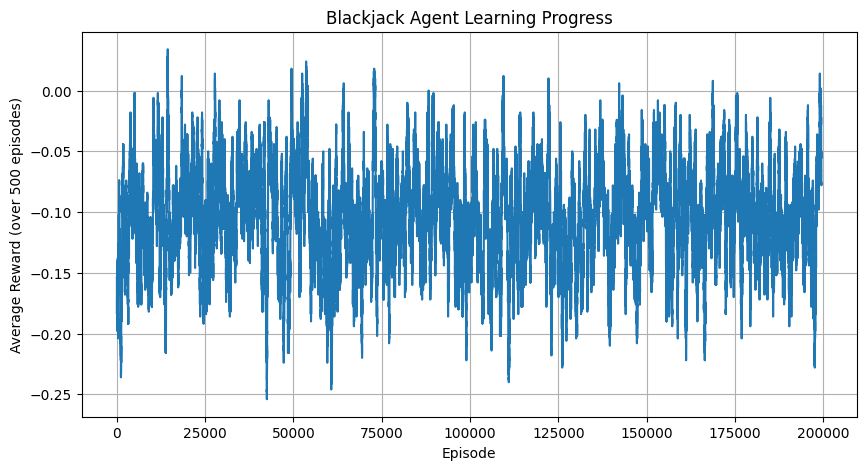

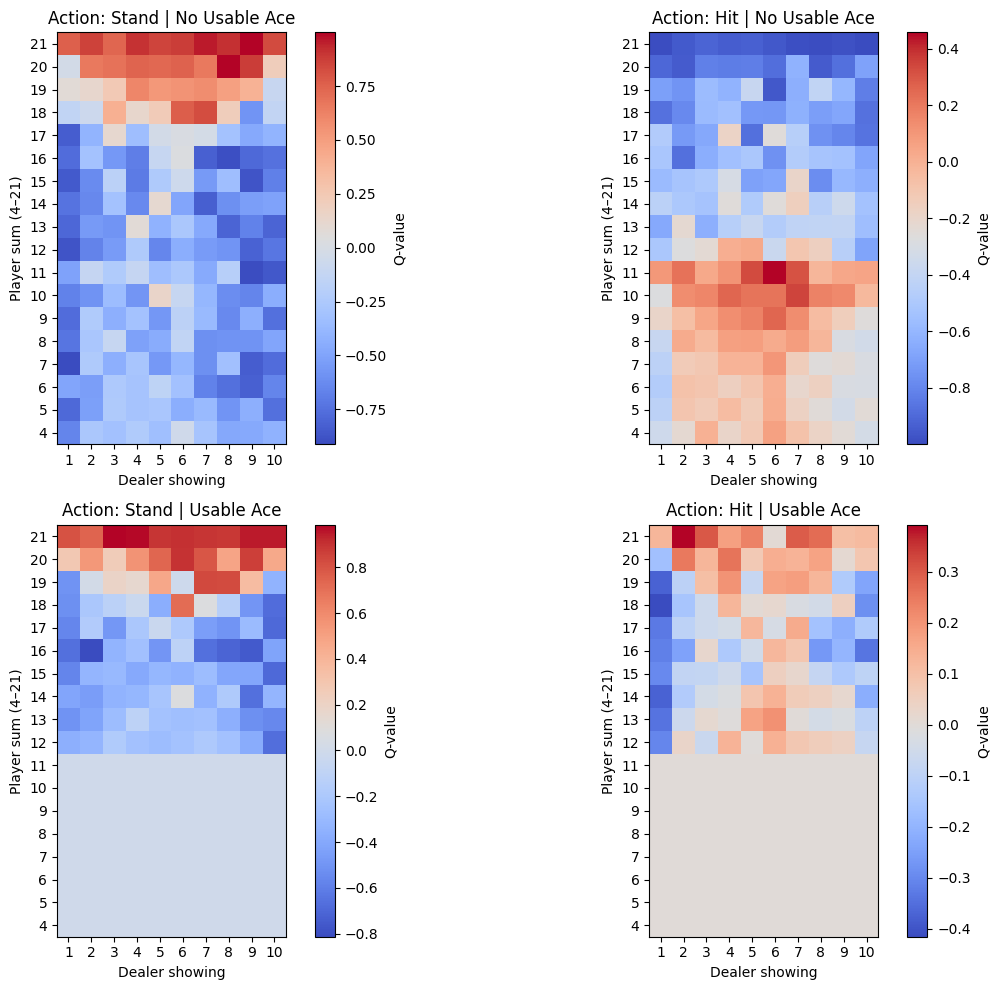

In [13]:
window = 500
avg_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(avg_rewards)
plt.title('Blackjack Agent Learning Progress')
plt.xlabel('Episode')
plt.ylabel(f'Average Reward (over {window} episodes)')
plt.grid(True)
plt.show()

# Q-table heatmaps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
actions = ['Stand', 'Hit']
usable_labels = ['No Usable Ace', 'Usable Ace']

for i, usable_ace in enumerate([0, 1]):
    for j, action in enumerate([0, 1]):  # 0=Stand, 1=Hit 
        ax = axes[i, j]
        q_vals = agent.q_table[4:22, 1:11, usable_ace, action].detach().numpy()
        im = ax.imshow(q_vals, cmap='coolwarm', origin='lower')

        ax.set_title(f'Action: {actions[j]} | {usable_labels[i]}')
        ax.set_xlabel('Dealer showing')
        ax.set_ylabel('Player sum (4–21)')
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(18))
        ax.set_yticklabels(range(4, 22))
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Q-value')

plt.tight_layout()
plt.show()

## Deep Q-Learning (DQN)

The examples shown in the Q-Learning section demonstrated how we can train an agent on simple environments using a Q-table.
However, traditional (tabular) Q-Learning has two major limitations:

1. **The state and action spaces must be discrete**, since Q-values are stored in a table.
2. **The Q-table becomes extremely large** when the state space grows (e.g. image inputs, continuous control, or large environments).
   Storing and updating millions of entries becomes impractical.

Therefore, in many real-world applications, classical Q-learning is not a good solution.

### **Deep Q-Learning** provides an alternative.

Instead of explicitly storing all state–action pairs in a Q-table, we train a **neural network** to approximate the Q-function:

$$
Q(s, a) \approx \text{NeuralNetwork}(s)[a]
$$

This network, called a **Q-Network**, takes the state as input and outputs a vector of Q-values — one for each possible action.

**In simple words:** Instead of learning from and updating a huge lookup table, we use a neural network that **generalizes from experience** and can learn value estimates for states it has never seen before. What is important, in Deep Q-Learning method, our `state` space can be continuous, as we will use Neural Networks for processing, however the action space should be still discrete (selecting max value from output)!

---

## TODO

Define a small **QNetwork** class, consisting of **three fully-connected (linear) layers** with **ReLU activations** between them:

* Input dimension: `state_dim`
* Output dimension: `action_dim`
* Hidden layer size: `64`
* Activation: `ReLU` (between layers only, not after last layer)

In [14]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            
            nn.Linear(64, 64),
            nn.ReLU(),
            
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.model(x)

We will use DQL on the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment. It is a classic control problem, where we have an inverted pendulum mounted on a cart, and the goal is to keep the pole balanced for as long as possible.

In this environment, the **action space** is `Discrete(2)`, which means we can apply a fixed force to push the cart either to the **left** or to the **right**.
The **state** is described by four continuous values: the cart position, cart velocity, pole angle, and pole angular velocity.

In [15]:
env = gym.make('CartPole-v1')
observation, info = env.reset()

print("Initial Observation:", observation)

action_space = env.action_space
state_space = env.observation_space

print("Action Space:", action_space)
print("State Space:", state_space)

Initial Observation: [ 0.02866135 -0.00245567 -0.03694793  0.04623307]
Action Space: Discrete(2)
State Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


## How to train Q-Network

We start by defining the **loss** used to train our Q-network.

For a batch of transitions ((s, a, r, s', done)) we:

1. Use the Q-network (`q_net`) to compute the **predicted Q-values** for the chosen actions:
   $$
   Q(s, a)
   $$
2. Build the **target Q-values** using the Bellman equation:
   $$
   y = r + \gamma \max_{a'} Q(s', a')
   $$
   and if `done` is `True`, the future term is zero:
   $$
   y = r \quad \text{when episode ended}
   $$
3. Define the loss as the **mean squared error** between prediction and target:
   $$
   \text{loss} = \big( Q(s, a) - y \big)^2
   $$

Minimizing this loss with gradient descent makes the network’s predictions closer to the Bellman target and gradually approximates the optimal Q-function.

We could plug it in and try to train our model on actual state of environment and update it. However, this might be very unstable. To prevent it, we will introduce **two** modifications, using `two Q-networks` and `replay buffering`.

### Why do we train **two** models?

If we used only one Q-network to compute both:

* the **predicted value** (Q(s, a)), and
* the **target value** ($\max_{a'} Q(s', a')$),

then both sides of the loss function would be changing at the same time.
This makes learning very **unstable** and causes oscillations or divergence, because the network is trying to chase a target that moves every update step.

To stabilize training, we introduce a **second network**, called the **target network**:

* `q_net` — updated at every training step using gradient descent,
* `target_net` — a periodically updated copy of `q_net`, used only to compute targets.

The target network is updated much less frequently (e.g. every 10 episodes), which keeps the target values fixed for a while and greatly improves stability.


### Why do we need a replay buffer?

Even with two networks, training would still be unstable if we trained from **consecutive transitions** from the environment, because:

* neighboring states are highly correlated,
* learning becomes biased by the most recent experience,
* the model could overfit to short sequences of states.

To solve this, we store each transition ((s, a, r, s', done)) in a **replay buffer**, and during training we **sample random batches** of transitions.

Below is already implemented class `ReplayBuffer`, which adds new values from environment (state, action, reward, next_state and done) to tensors with limited `capacity` and we can randomly sample from it batch of data.

In [16]:
class ReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.ptr = 0
        self.full = False
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros(capacity, dtype=torch.int64, device=device)
        self.rewards = torch.zeros(capacity, dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.dones = torch.zeros(capacity, dtype=torch.float32, device=device)

    def add(self, s, a, r, ns, d):
        self.states[self.ptr] = torch.as_tensor(s, dtype=torch.float32, device=device)
        self.actions[self.ptr] = a
        self.rewards[self.ptr] = r
        self.next_states[self.ptr] = torch.as_tensor(ns, dtype=torch.float32, device=device)
        self.dones[self.ptr] = d

        self.ptr += 1
        if self.ptr >= self.capacity:
            self.ptr = 0
            self.full = True

    def sample(self, batch_size):
        max_idx = self.capacity if self.full else self.ptr
        idx = torch.randint(0, max_idx, (batch_size,), device=device)
        return (self.states[idx], self.actions[idx], self.rewards[idx],
                self.next_states[idx], self.dones[idx])

With the **ReplayBuffer** in place, we can now train our agent using Deep Q-Learning.

We start by initializing both networks, `q_net` and `target_net`, with the same input and output dimensions (`state_dim → action_dim`). Right after creation, we copy the parameters from `q_net` to `target_net` using `state_dict()` and `load_state_dict(...)`. This means both networks start with identical weights.

We also initialize the replay buffer with a capacity of `100_000`, which means it can store up to 100,000 past transitions `(state, action, reward, next_state, done)`.

---

### Main training loop

In the main episode loop:

1. We **reset** the environment using `env.reset()` and obtain the initial `state`.
2. While the episode is not finished (`done == False`):

   * We select an action using the **ε-greedy policy**:

     * with probability `epsilon`, we sample a random action from `env.action_space` (exploration),
     * otherwise, we convert the current `state` to a tensor, pass it through `q_net`, and choose the action with the highest predicted Q-value (`argmax` over the network output).
   * We then apply this action to the environment using `env.step(action)`, which returns (`next_state`, `reward`, `terminated`, `truncated`, `info`).
   * We define `done = terminated or truncated` to detect whether the episode has ended.
   * We store the transition `(state, action, reward, next_state, done)` in the **replay buffer**.
   * We update `state = next_state` and accumulate `total_reward` for this episode.
   * We call `train_step()` to update the network.

After the episode ends, we:
* update `epsilon` with decay (`epsilon = max(epsilon * epsilon_decay, epsilon_min)`),,
* store `total_reward` in `rewards_history`,

---

### Training step

The `train_step()` function is responsible for a single optimization step of DQN.
Training is applied **only if** we already have at least `batch_size` transitions stored in the `ReplayBuffer`. If not, the function returns immediately (we don’t have enough data yet).

Once we have enough data:

1. We **sample** a random batch of `batch_size` transitions from the buffer (`states, actions, rewards, next_states, dones`).

2. We compute the **current Q-values** for the chosen actions using `q_net`:

   * pass `states` through `q_net`
   * use `.gather(1, actions.unsqueeze(1)).squeeze(1)` to select Q-values corresponding to the actually taken actions.

3. We compute the **next Q-values** using the `target_net`:

   * pass `next_states` through `target_net`,
   * take the maximum over actions: `max(1)[0]`,
   * detach from the graph so gradients do not flow into the target network.

4. We build the **target values** using the Bellman equation and taking into account terminal states:

   $$
   \text{target} = r + \gamma \cdot \max_{a'} Q_{\text{target}}(s', a') \cdot (1 - \text{done})
   $$

   * if `done = 1`, the future term is zero → `target = r`
   * if `done = 0`, we add the discounted next Q-value.

5. We compute the **loss** as the mean squared error between:

   * predicted `q_values` from `q_net`,
   * and the `target` values computed above.

6. We perform a standard optimizer step:

   * zero gradients,
   * backpropagate the loss,
   * update `q_net` parameters using Adam.

Every 10 episodes, we refresh the `target_net` parameters by copying the weights from `q_net` again.


## TODO

Finish `train_step` function.

In [17]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

lr = 1e-3
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
batch_size = 64
episodes = 700

# Initialisation
q_net = QNetwork(state_dim, action_dim).to(device)
target_net = QNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(q_net.state_dict())

optimizer = optim.Adam(q_net.parameters(), lr=lr)

replay_buffer = ReplayBuffer(100_000, state_dim)

rewards_history = []

# Training step DQN
def train_step():
    if replay_buffer.ptr < batch_size and not replay_buffer.full:
        return

    # 1. Sample minibatch
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # 2. Compute current Q-values from q_net
    # q_values shape = (batch_size,)
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # 3. Compute next Q-values from target_net (detached)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]

    # 4. Compute target using Bellman equation
    targets = rewards + gamma * next_q_values * (1 - dones)

    # 5. Compute loss (mean squared error)
    loss = nn.MSELoss()(q_values, targets)

    # 6. Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Main for loop
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        
        # Epsilon-greedy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_t = torch.as_tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
                action = q_net(state_t).argmax(1).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        replay_buffer.add(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        train_step()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards_history.append(total_reward)

    if episode % 10 == 0:
        target_net.load_state_dict(q_net.state_dict())

env.close()

100%|██████████| 700/700 [00:57<00:00, 12.19it/s]


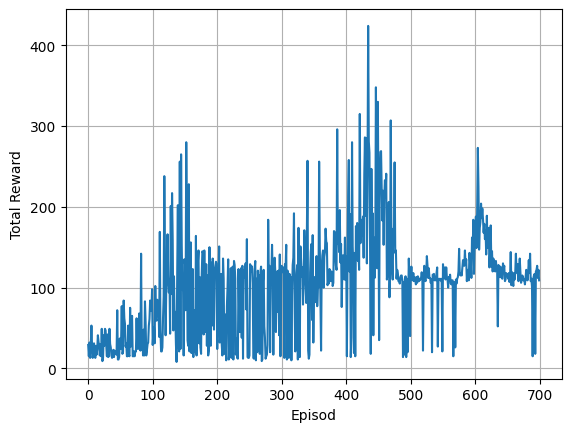


=== VISUALISATION ===


/home/karolina/studia/gsn/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists



Total reward: 105.0


In [18]:
plt.plot(rewards_history)
plt.xlabel("Episod")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# VIsualisation
env = gym.make("CartPole-v1", render_mode="rgb_array")  # we can change to "human" for real visualiastion
frames = []
state, _ = env.reset()
done = False
total_reward = 0

q_net.eval()
q_net.epsilon = 0.0  # we remove exploration

print("\n=== VISUALISATION ===")

iter = 0
while not done:
    iter += 1
    frame = env.render()
    frames.append(frame)

    with torch.no_grad():
        action = q_net(torch.tensor(state, dtype=torch.float32, device=device)).argmax().item()

    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    total_reward += reward
    state = next_state
    time.sleep(0.02)

    if iter == 10000:
        break

print(f"\nTotal reward: {total_reward:.1f}")
env.close()

imageio.mimsave("cartpole_agent.gif", frames, fps=30)
